In [44]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

In [45]:
data_hour = pd.read_csv('./hourly_dataset.csv') #每小时间隔流量数据集，含20个小区（01-20），多个表格间对于小区的编码一致
sub       = pd.read_csv('./sample_submission.csv') #提交样例
test      = pd.read_csv('./test_public.csv') #测试集（小时单位），须提交20个小区、4个不连续周的供水量。也即672（小时数） x 20（小区数）的矩阵
weather   = pd.read_csv('./weather.csv') #深圳市天气数据，测试集部分假定未知

def time_transfer(df):
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values(by=['time'])
    return df

data_hour = time_transfer(data_hour)
weather = time_transfer(weather)
# data_hour = pd.merge(data_hour,weather,on=['time','train or test'],how='left')
for i in range(20):
    data_hour[f'flow_{i+1}'][data_hour[f'flow_{i+1}']<0] = 0

In [46]:
data_hour = pd.read_csv('./hourly_dataset.csv') #每小时间隔流量数据集，含20个小区（01-20），多个表格间对于小区的编码一致
sub       = pd.read_csv('./sample_submission.csv') #提交样例
test      = pd.read_csv('./test_public.csv') #测试集（小时单位），须提交20个小区、4个不连续周的供水量。也即672（小时数） x 20（小区数）的矩阵
weather   = pd.read_csv('./weather.csv') #深圳市天气数据，测试集部分假定未知


data_hour = time_transfer(data_hour)
weather = time_transfer(weather)


# data_hour = pd.merge(data_hour,weather,on=['time','train or test'],how='left')
for i in range(20):
    data_hour[f'flow_{i+1}'][data_hour[f'flow_{i+1}']<0] = np.nan



In [47]:
test_list1 = test.groupby('train or test')['time'].first().reset_index()
test_list1 = test_list1['time'].values.tolist()
test_list2 = test.groupby('train or test')['time'].last().reset_index()
test_list2 = test_list2['time'].values.tolist()
test_list1.extend(test_list2)
test_list1.sort()

# train1 test1
train1_ = data_hour[data_hour['time']<test_list1[0]].reset_index(drop=True)
test1_  = data_hour[(data_hour['time']>=test_list1[0]) & (data_hour['time']<=test_list1[1])].reset_index(drop=True)
#train2 test2
train2_ = data_hour[(data_hour['time']>test_list1[1])  & (data_hour['time']<test_list1[2])].reset_index(drop=True)
test2_  = data_hour[(data_hour['time']>=test_list1[2]) & (data_hour['time']<=test_list1[3])].reset_index(drop=True)
#train3 test3
train3_ = data_hour[(data_hour['time']>test_list1[3])  & (data_hour['time']<test_list1[4])].reset_index(drop=True)
test3_  = data_hour[(data_hour['time']>=test_list1[4]) & (data_hour['time']<=test_list1[5])].reset_index(drop=True)
#train4 test4
train4_ = data_hour[(data_hour['time']>test_list1[5])  & (data_hour['time']<test_list1[6])].reset_index(drop=True)
test4_  = data_hour[(data_hour['time']>=test_list1[6]) & (data_hour['time']<=test_list1[7])].reset_index(drop=True)

In [48]:
def preprocess_single_flow(train, flow):
    if np.isnan(train.loc[0, flow]):
        train.loc[0, flow] = train.loc[:, flow].mean()
    #最后一个值为nan，就标记为有值
    if np.isnan(train.loc[len(train)-1, flow]):
        train.loc[len(train)-1, flow] = 0
    cur_train = train[flow].copy()
    cur_train[cur_train.notnull()]=0
    cur_train[cur_train.isnull()]=1
    begin_index = cur_train.diff()[cur_train.diff()==1].index.values.tolist()
    end_index = cur_train.diff()[cur_train.diff()==-1].index.values.tolist()
    for index in range(len(begin_index)):
        fill_null = train[flow].loc[begin_index[index]-1]/(end_index[index]-begin_index[index]+1)
        # 异常值均匀化填补空值
        train[flow].loc[begin_index[index]-1:end_index[index]-1] = fill_null
    return train[flow]

def preprocess_all_flow(train):
    for i in range(20):
        train[f'flow_{i+1}'] = preprocess_single_flow(train, f'flow_{i+1}')
    return train

train1_ = preprocess_all_flow(train1_)
train2_ = preprocess_all_flow(train2_)
train3_ = preprocess_all_flow(train3_)
train4_ = preprocess_all_flow(train4_)

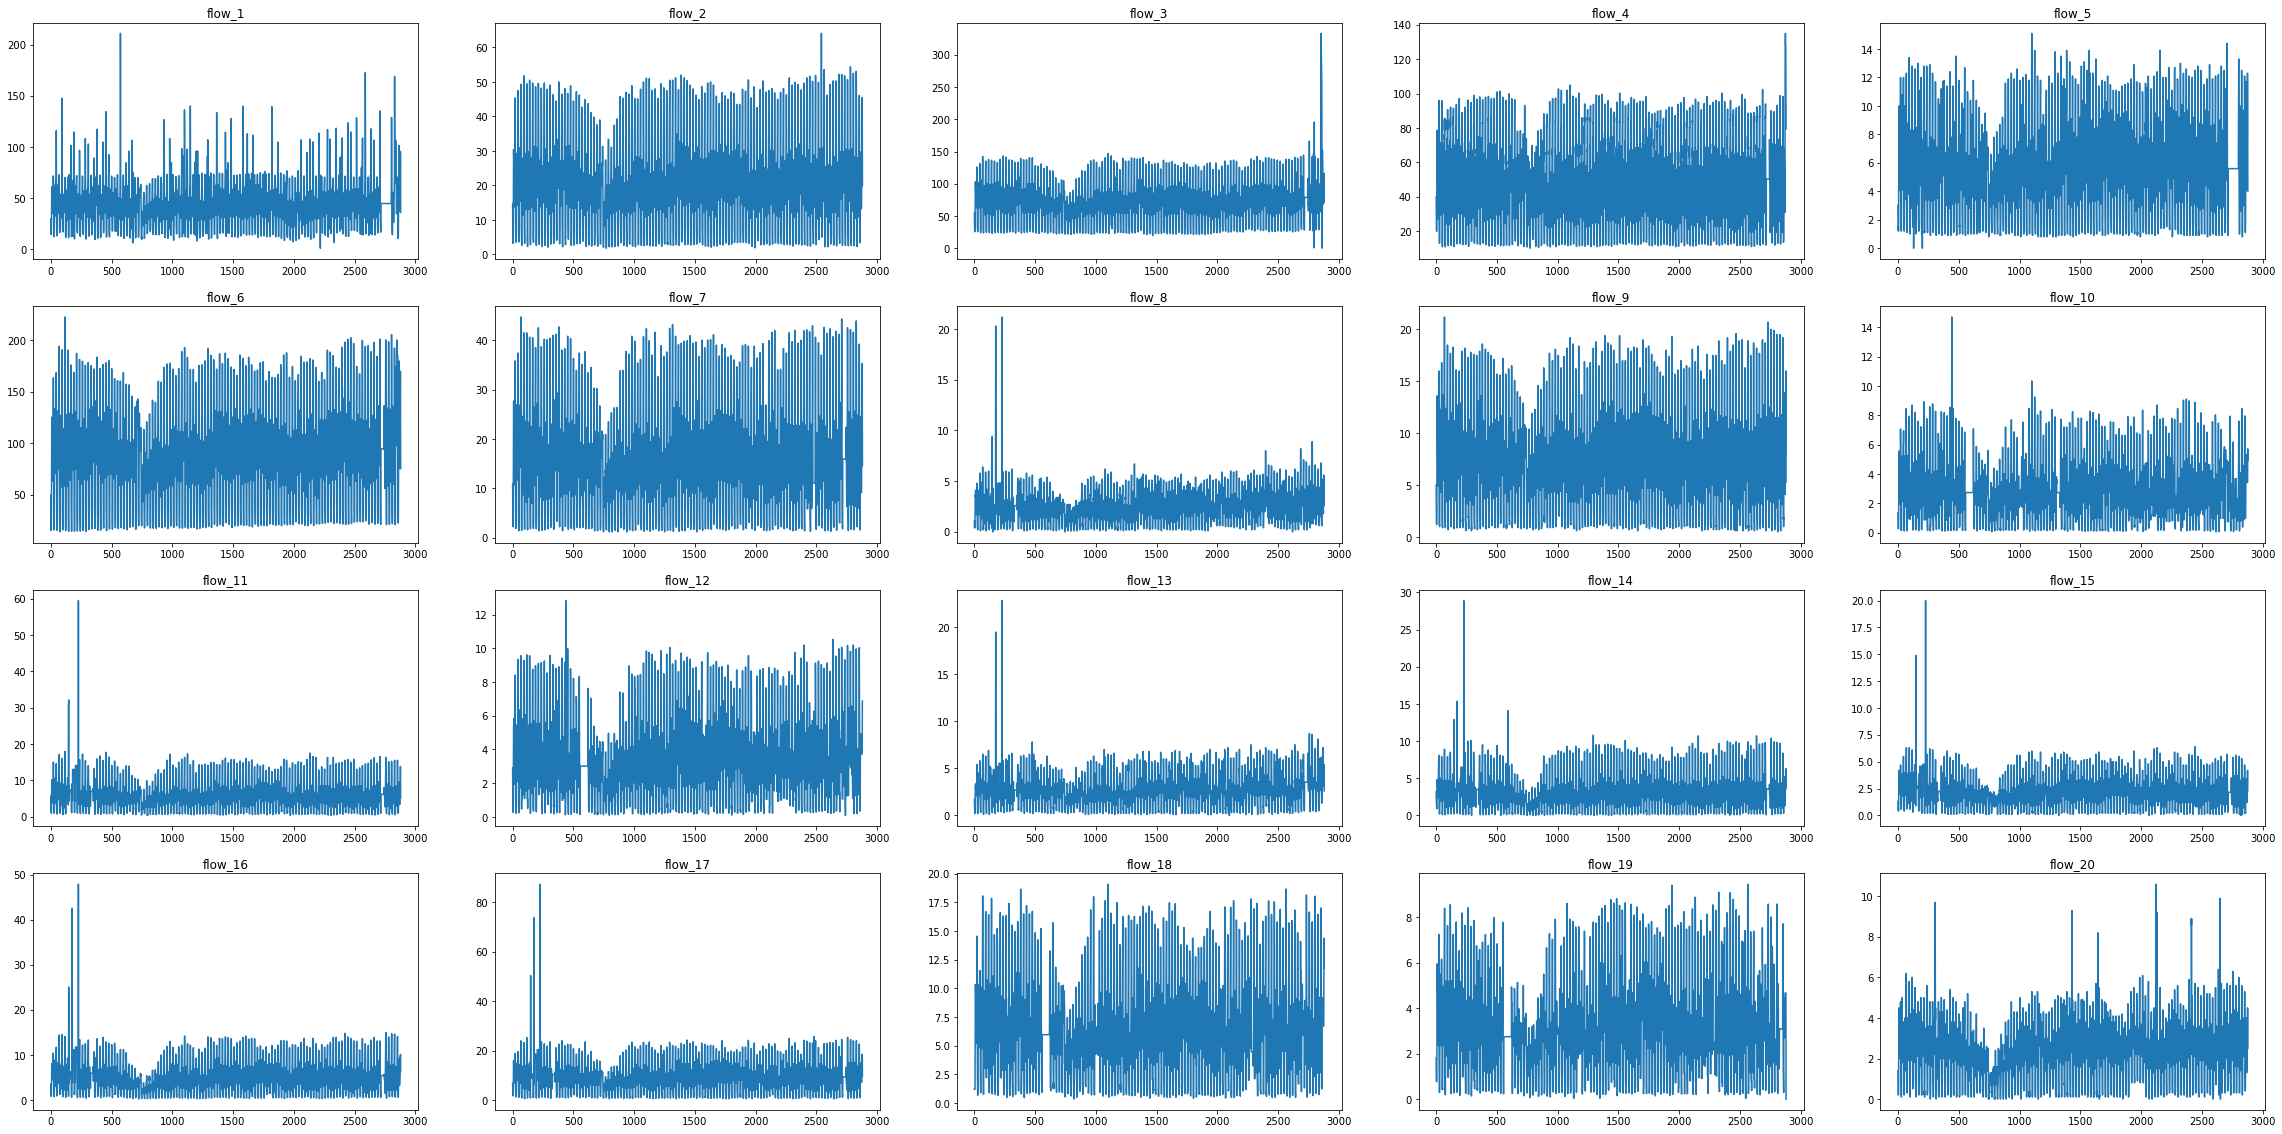

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 20))

for i in range(1,21):
    flow = f'flow_{i}'
    plt.subplot(4, 5, i)
    plt.plot(range(len(train1_[flow])), train1_[flow])
    plt.title(flow)

In [50]:
def make_diff_features(df, flow):
    seq_len = 7*24
    df[f"{flow}_simple_diff1"] = df[flow].diff()
    df[f"{flow}_simple_shift24"] = df[flow].shift(24)
    df[f"{flow}_simple_diff168"] = df[flow].diff(seq_len)
    return df

def make_trigonometric_features(df, flow, n=24):
    df[f'{flow}_sin'] = round(np.sin(2*np.pi/n*df[flow]), 6)
    df[f'{flow}_cos'] = round(np.cos(2*np.pi/n*df[flow]), 6)
    return df.iloc[:,-2:]

def make_feas(data):
    data = data.drop(['time','train or test'],axis=1)
    cur1, cur2 = [], []
    for flow in tqdm(range(20)):
        train_data_x = pd.DataFrame(data.loc[:,[f'flow_{flow+1}']]) #,'R', 'fx', 'T', 'U', 'fs', 'V', 'P']])
        cur1.append(make_diff_features(train_data_x, f'flow_{flow+1}').interpolate().fillna(method='bfill'))
        cur2.append(make_trigonometric_features(train_data_x, f'flow_{flow+1}', n=24))
    cur1 = np.stack(cur1,axis=0).transpose(1,0,2)
    cur2 = np.stack(cur2,axis=0).transpose(1,0,2)
    return np.concatenate((cur1,cur2), axis=2)

def generate_dataset(data, seq_len, pre_len, split_ratio=0.8):
    train_x, train_y, val_x, val_y, test_x = [], [], [], [], np.expand_dims(data[-pre_len:],axis=[0])
    split_size = int(len(data)*split_ratio)
    train_data = data[:split_size]
    val_data   = data[split_size:]
    for i in range(0, len(train_data)-seq_len-pre_len, seq_len):
        train_x.append(train_data[i:i+seq_len])
        train_y.append(train_data[i+seq_len:i+seq_len+pre_len])
    for i in range(0, len(val_data)-seq_len-pre_len, seq_len):
        val_x.append(val_data[i:i+seq_len])
        val_y.append(val_data[i+seq_len:i+seq_len+pre_len])
    train_x, train_y, val_x, val_y = np.array(train_x), np.array(train_y), np.array(val_x), np.array(val_y)
    return train_x, train_y, val_x, val_y, test_x
# 做特征
a = make_feas(train1_)
b = make_feas(pd.concat([train1_,train2_]))
c = make_feas(pd.concat([train1_,train2_,train3_]))
d = make_feas(pd.concat([train1_,train2_,train3_,train4_]))
print(a.shape, b.shape, c.shape, d.shape)
# 构造x和y数据
train1_x, train1_y, val1_x, val1_y, test1_x = generate_dataset(a, 24*7, 24*7)
train2_x, train2_y, val2_x, val2_y, test2_x = generate_dataset(b, 24*7, 24*7)
train3_x, train3_y, val3_x, val3_y, test3_x = generate_dataset(c, 24*7, 24*7)
train4_x, train4_y, val4_x, val4_y, test4_x = generate_dataset(d, 24*7, 24*7)

100%|██████████| 20/20 [00:00<00:00, 202.75it/s]

(2880, 20, 6) (3456, 20, 6) (4488, 20, 6) (5064, 20, 6)


In [55]:
def lightgbm_train(train_x, train_y, val_x, val_y, test_x):
    fea_nums = train_x.shape[-1]
    scores = []
    predictions = []
    for flow in tqdm(range(20)):
        train_data_x = pd.DataFrame(train_x[:, :, flow, :].reshape(-1, fea_nums))
        train_data_y = pd.DataFrame(train_y[:, :, flow, :].reshape(-1, fea_nums)).iloc[:,0]
        val_data_x   = pd.DataFrame(val_x[:, :, flow, :].reshape(-1, fea_nums))
        val_data_y   = pd.DataFrame(val_y[:, :, flow, :].reshape(-1, fea_nums)).iloc[:,0]
        test_data_x  = pd.DataFrame(test_x[:, :, flow, :].reshape(-1, fea_nums))

        train_part = lgb.Dataset(train_data_x, train_data_y)
        val_part = lgb.Dataset(val_data_x, val_data_y)
        ESR = 100
        NBR = 3000
        VBE = 100
        lgb_params_best = {'objective': 'regression',
                           'metric': ['mse'],
                           'bagging_seed': 2022,
                           'verbose': -1}
        lgb_model = lgb.train(lgb_params_best, train_part, num_boost_round=NBR,
                              valid_sets=[train_part, val_part],
                              valid_names=['train', 'valid'],
                              early_stopping_rounds=ESR, verbose_eval=None)
        score = mean_squared_log_error(val_data_y, lgb_model.predict(val_data_x))
        scores.append(round(score, 3))
        prediction_test = lgb_model.predict(test_data_x)
        predictions.append(prediction_test)
    return predictions, scores

In [56]:
predictions1, scores1 = lightgbm_train(train1_x, train1_y, val1_x, val1_y, test1_x)
print(scores1)
predictions2, scores2 = lightgbm_train(train2_x, train2_y, val2_x, val2_y, test2_x)
print(scores2)
predictions3, scores3 = lightgbm_train(train3_x, train3_y, val3_x, val3_y, test3_x)
print(scores3)
predictions4, scores4 = lightgbm_train(train4_x, train4_y, val4_x, val4_y, test4_x)
print(scores4)

100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[0.072, 0.032, 0.011, 0.018, 0.028, 0.018, 0.06, 0.051, 0.035, 0.073, 0.038, 0.063, 0.052, 0.049, 0.033, 0.045, 0.053, 0.07, 0.06, 0.06]


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


[0.091, 0.026, 0.125, 0.033, 0.064, 0.036, 0.065, 0.054, 0.027, 0.083, 0.036, 0.075, 0.049, 0.042, 0.031, 0.043, 0.05, 0.08, 0.078, 0.046]


100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


[0.067, 0.017, 0.071, 0.064, 0.048, 0.046, 0.033, 0.031, 0.016, 0.081, 0.023, 0.115, 0.033, 0.024, 0.023, 0.026, 0.03, 0.097, 0.075, 0.046]


100%|██████████| 20/20 [00:02<00:00,  6.86it/s]

[0.057, 0.015, 0.024, 0.056, 0.03, 0.039, 0.021, 0.034, 0.015, 0.079, 0.029, 0.113, 0.053, 0.164, 0.022, 0.022, 0.021, 0.078, 0.07, 0.041]


In [57]:
result = np.concatenate((np.vstack(predictions1).transpose(1,0),
                         np.vstack(predictions2).transpose(1,0),
                         np.vstack(predictions3).transpose(1,0),
                         np.vstack(predictions4).transpose(1,0)))
result[result<0]=0
result = pd.concat([sub['time'],pd.DataFrame(result)],axis=1)
result.columns = sub.columns
result.to_csv('./lgb_baseline.csv',index=False,encoding='utf-8')
result

,time,flow_1,flow_2,flow_3,flow_4,flow_5,flow_6,flow_7,flow_8,flow_9,...,flow_11,flow_12,flow_13,flow_14,flow_15,flow_16,flow_17,flow_18,flow_19,flow_20
0,2022-05-01 01:00:00,27.389079,9.502306,41.833990,26.109832,2.056471,40.377401,5.281709,1.401368,2.380204,...,3.190930,1.837489,1.697738,1.511902,1.314025,2.914864,5.294540,3.517959,1.258671,1.145361
1,2022-05-01 02:00:00,23.365480,5.777398,33.852657,16.591965,1.664755,26.322240,2.633624,0.727537,1.507162,...,1.576583,1.859844,0.828621,0.937811,0.969089,1.617117,2.575767,3.474590,0.652922,0.406492
2,2022-05-01 03:00:00,16.755844,4.662347,31.369855,15.250965,1.520786,23.828937,2.433345,0.462346,1.467690,...,1.261969,1.824332,0.623808,0.431007,0.634798,0.982472,1.886926,3.474590,0.688573,0.406492
3,2022-05-01 04:00:00,16.112733,3.458583,29.599846,14.565086,1.385118,22.453923,2.433345,0.495045,1.424565,...,1.239932,1.824332,0.609861,0.413893,0.457583,0.819958,1.886926,3.493408,0.771009,0.379843
4,2022-05-01 05:00:00,19.646447,4.246182,31.369855,19.334076,1.574777,31.697681,2.800271,0.626402,1.799237,...,1.261969,1.173412,0.623808,0.650379,0.547454,0.924543,1.886926,1.492081,1.081218,0.789254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2022-08-27 20:00:00,73.771112,27.925185,92.554754,65.068578,8.416568,115.833822,24.354934,3.355050,10.847602,...,7.551827,4.575832,4.803189,5.093468,2.973478,8.051120,13.248499,15.630885,3.913263,3.797498
668,2022-08-27 21:00:00,53.434278,39.971723,117.034104,69.795244,10.255871,151.185096,34.564104,4.171033,15.185910,...,11.091700,6.354456,5.702553,7.556616,4.357115,11.869051,17.548515,16.937163,5.543901,4.235096
669,2022-08-27 22:00:00,76.457519,40.921783,119.443602,77.920394,11.326252,150.721233,38.300251,4.928403,17.041513,...,13.668444,7.610836,6.441895,7.988677,3.875439,11.810795,20.238062,16.313910,6.954657,4.680718
670,2022-08-27 23:00:00,59.758198,31.722492,93.446891,85.960818,7.162368,116.186520,26.112794,4.029169,11.637624,...,9.187816,6.320177,6.337280,7.527812,4.360857,12.587781,15.983719,16.699349,6.960167,4.827565


In [58]:
avg_scores1 = 1 / (1 + sum(scores1)/len(scores1))
print(scores1, avg_scores1)

avg_scores2 = 1 / (1 +sum(scores2)/len(scores2))
print(scores2, avg_scores2)

avg_scores3 = 1 / (1 + sum(scores3)/len(scores3))
print(scores3, avg_scores3)

avg_scores4 = 1 / (1 +sum(scores4)/len(scores4))
print(scores4, avg_scores4)

[0.072, 0.032, 0.011, 0.018, 0.028, 0.018, 0.06, 0.051, 0.035, 0.073, 0.038, 0.063, 0.052, 0.049, 0.033, 0.045, 0.053, 0.07, 0.06, 0.06] 0.9559772477415038
[0.091, 0.026, 0.125, 0.033, 0.064, 0.036, 0.065, 0.054, 0.027, 0.083, 0.036, 0.075, 0.049, 0.042, 0.031, 0.043, 0.05, 0.08, 0.078, 0.046] 0.9463423866754992
[0.067, 0.017, 0.071, 0.064, 0.048, 0.046, 0.033, 0.031, 0.016, 0.081, 0.023, 0.115, 0.033, 0.024, 0.023, 0.026, 0.03, 0.097, 0.075, 0.046] 0.9539254030334827
[0.057, 0.015, 0.024, 0.056, 0.03, 0.039, 0.021, 0.034, 0.015, 0.079, 0.029, 0.113, 0.053, 0.164, 0.022, 0.022, 0.021, 0.078, 0.07, 0.041] 0.9531525520659582
